# Four-pass chapter break analysis

Reads novels marked with chapter-break tags, and creates a sequence of (roughly) 900-word chunks such that the chunk-divisions sometimes align with chapter breaks, and sometimes run across them, but every chapter break is guaranteed to align with at least one chunk-division.

To ensure this, it makes four passes across each book, at 250-word offsets.

We start by importing needed modules, defining a pretty-print function, and importing credentials (from a file not in the repo, of course!)

In [4]:
from glob import glob
import pandas as pd
from nltk.tokenize import sent_tokenize
import textwrap
import random

import time
import backoff
import math
import openai

import seaborn as sns

def print_wrapped_text(text, width=70):
    texts = text.split('\n')
    if len(texts) > 1:
        for t in texts:
            print_wrapped_text(t, width=70)

    else:
        text = texts[0]
        wrapper = textwrap.TextWrapper(width=width)
        wrapped_text = wrapper.fill(text)
        print(wrapped_text)
    
with open('credentials.txt', encoding = 'utf-8') as f:
    organization = f.readline().strip()
    api_key = f.readline().strip()
    
client = openai.OpenAI(organization=organization, api_key=api_key)

#### Available texts

Each of these texts has been marked up by inserting tags to mark the location of chapter breaks (and other important breaks in the text).

```<*CHAP-H*>``` marks a new chapter **h**eading. ```<*CHAP-HI*>``` indicates a new serial **i**nstallment (that aligns with a chapter heading). ```<*CHAP-N*>``` indicates a new **n**arrator or point-of-view (not in this case aligned with a chapter heading.

In [2]:
files = glob('chapterbooks/*.txt')
files

['chapterbooks/CuriousBride.txt',
 'chapterbooks/CopperCylinder.txt',
 'chapterbooks/AuroraFloydGB.txt',
 'chapterbooks/LeagesUnderGB.txt',
 'chapterbooks/HoundOfTheBaskervilles.txt',
 'chapterbooks/LuttrellOfAranGB.txt',
 'chapterbooks/WomaninWhiteGB.txt',
 'chapterbooks/Persuasion.txt',
 'chapterbooks/VanityFairGB.txt',
 'chapterbooks/OurMutualFriend.txt',
 'chapterbooks/MurderIsDangerous.txt']

### Average 'chapter' lengths

I put the scare quotes around "chapter" because this includes breaks that don't align with chapter headings (serial installments don't always align, for instance). So it's more accurately just the average space between break tags.

In [5]:
tokens = []

for file in files:
    with open(file, mode = 'r', encoding = 'utf-8') as f:
        filetext = f.read()
        filetokens = filetext.split()
        tokens.append(filetokens)

counts = []

for ft in tokens:
    ctr = 0
    for t in ft:
        if t.startswith('<*CH'):
            counts.append(ctr)
            ctr = -1
        else:
            ctr += 1    

<AxesSubplot:ylabel='Count'>

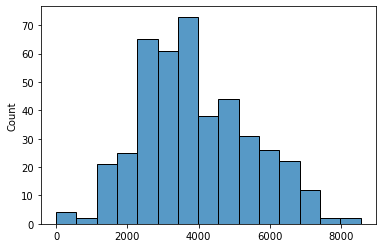

In [6]:
sns.histplot(counts)

### Utility functions for aligning chunks with sentences and chapters

These will be used below to ensure that we break our chunks for analysis at sentences (while obeying a loosely 900-word rhythm).

In [25]:
def closest_sentence_index(sentence_indexes, target):
    """
    This function takes a list of numbers in ascending order (sentence_indexes) and a number (target).
    It returns the sentence_index that is closest to the target, regardless of whether it is greater or less than the target.
    """
    # Handling the case where sentence_indexes is empty
    if not sentence_indexes:
        return None

    # Initialize variables to store the closest index and its difference from target
    closest_index = sentence_indexes[0]
    min_difference = abs(target - sentence_indexes[0])

    # Iterate through the list to find the closest index
    for index in sentence_indexes:
        difference = abs(target - index)
        if difference < min_difference:
            min_difference = difference
            closest_index = index

    return closest_index

# Example usage
sentence_indexes = [10, 20, 30, 40, 50]
target = 33
closest_sentence_index(sentence_indexes, target)


30

In [24]:
def sentence_indexes_within_range(sentence_indexes, target, range_val=70):
    """
    This function takes a list of numbers in ascending order (sentence_indexes), a number (target),
    and a range value (range_val). It returns a list of all sentence_indexes that are within the specified
    range of the target.
    """
    # Filter and return the indexes within the specified range of the target
    return [index for index in sentence_indexes if abs(target - index) <= range_val]

# Example usage
sentence_indexes = [-20, 200]
target = 80
sentence_indexes_within_range(sentence_indexes, target)


[]

### Key chunking functions

The first function here divides a novel into sentences, marking the location of "divides" both between sentences and between chapters. It's assisted by a function that fuses short sentences (fewer than five words), and breaks very long ones (more than 200 words).

Then ```get_bookruns``` uses that data to construct a sequence of four passes through the novel that should hit all (or nearly all) the chapter breaks without greatly distorting chunk length. We do this by making four different passes at 900-word intervals, with a 250-word offset between each pass.

Since we want to break at sentences, the chunks are never *exactly* 900 words long. Moreover, we align chunks with chapter breaks when the chapter break is sufficiently close (within 130 words of the "ideal" 900-word rhythm). We allow stochastic variation for the other chunks as well, so the chunks on either side of a chapter break are not much more disparate in length than the average pair of chunks.

In [7]:
def chapterize_novel(inpath):
    '''
    This function does sentence-tokenization and records the
    ending word-positions for chapters as well as sentences.
    '''
    
    with open(inpath, mode = 'r') as f:
        thetext = f.read()
    thewords = thetext.split()
    print(len(thewords))
    chapters = []
    thischap = []
    chaptertypes = []
    for idx, word in enumerate(thewords):
        if word.startswith('<*CHAP') and word.endswith('*>'):
            # this is a chapter divider token
            chapters.append(' '.join(thischap))
            thischap = []
            chaptertype = word.replace('<*CHAP-', '').replace('*>', '')
            chaptertypes.append(chaptertype)
        else:
            thischap.append(word)
            
    chapters.append(' '.join(thischap))
    chaptertypes.append('EOF')
            
    alldivides = [0]
    allsentences = ['']
    
    # Note that we initialize these lists with a dummy sentence 
    # (containing no words) that ends at position zero.
    # This is necessary because we're defining alldivides as a list
    # of word positions where each sentence STOPS. But we want to use
    # it later in a context where we will be finding start- as well as
    # end-positions. So we need to have position zero available.
    
    ctr = 0
    chapterdivides = []
    
    for chapter, thetype in zip(chapters, chaptertypes):
        sentences = list(sent_tokenize(chapter))
        sentences = fuse_short_sentences(sentences)
        for s in sentences:
            sentlen = len(s.split())
            ctr += sentlen
            alldivides.append(ctr)
            allsentences.append(s)
        chapterdivides.append((ctr, thetype))
    
    booklen = ctr
    print(booklen)
    
    return allsentences, alldivides, chapterdivides, booklen
    

def fuse_short_sentences(sentences, word_limit = 5):
    '''
    Ensures sentences are not fewer than five words or more
    than 200 words.
    '''
    
    fused_sentences = []
    previous_sentence = ""

    for sentence in sentences:
        words = sentence.split()

        if len(words) < word_limit and previous_sentence:
            fused_sentences[-1] = fused_sentences[-1] + " " + sentence
        elif len(words) > 200:
            number_needed = (len(words) // 160) + 1
            print('200+ sentence ', number_needed)
            increment = len(words) // number_needed
            # Splitting the list into sublists and converting them into strings
            for i in range(number_needed):
                # Extracting a sublist of words
                sublist = words[i * increment : (i + 1) * increment]

                # Joining the words in the sublist to form a sentence
                sentence_part = ' '.join(sublist)

                # Appending the sentence to the fused_sentences list
                fused_sentences.append(sentence_part)

            # Handling the remaining words (if any) for the last sublist
            remaining_words = words[number_needed * increment:]
            if remaining_words:
                fused_sentences.append(' '.join(remaining_words))
                previous_sentence = ' '.join(remaining_words)
            else:
                previous_sentence = sentence_part
        else:
            fused_sentences.append(sentence)
            previous_sentence = sentence

    return fused_sentences

def get_bookruns(allsentences, alldivides, chapterdivides, booklen):
    
    '''
    We want to create four lists of chunks to use in prediction.
    Each list will represent chunks as 4-tuples, including
    a start-sentence-index,
    an end-sentence-index,
    a length-in-words,
    and a code characterizing haracterize the boundary at the end of the chunk as either
    'sentence' -- ends at an ordinary sentence boundary
    chaptertype -- a one-to-four letter code that indicates whether this is a chapter, installment, or
    point-of-view boundary
    or 'EOF' -- a code indicating this is the last chunk in the book.
    '''
    
    bookruns = []
    wordpoints = []
    
    for startblock in [0, 250, 500, 750]:
        idealpoints = [x for x in range(startblock, booklen, 900)]
        idealpoints.append(booklen)
        realpoints = []
        
        # First we attempt to match idealpoints with nearby
        # chapter divides. If we can match them, we record the chapter
        # type in a tuple
        
        for ideal in idealpoints:
            if ideal == 0:
                continue
            found = False
            for divide, thetype in chapterdivides:
                if ideal - 130 < divide and ideal + 130 > divide:
                    realpoints.append((divide, thetype))
                    found = True
            if not found:
                realpoints.append((ideal, False))
        
        characterized = []
        # mark points that are adjacent to chapter breaks
        # and need flexibility
        for idx, thetuple in enumerate(realpoints):
            point, thetype = thetuple
            if idx < 1:
                characterized.append(thetuple)
            elif idx + 1 == len(realpoints):
                characterized.append((point, 'EOF'))
            elif thetype: # anything not false
                characterized.append(thetuple)
            else:
                if realpoints[idx - 1][1] or realpoints[idx + 1][1]:
                    # this point is adjacent to a chapter boundary
                    characterized.append((point, 'adjacent'))
                else:
                    characterized.append(thetuple)
                    
        assert len(realpoints) == len(characterized)
        realpoints = characterized
        
        characterized = []
        for point, thetype in realpoints:
            if thetype != 'adjacent' and thetype != False:
                characterized.append((point, thetype))
            elif thetype == 'adjacent':
                # this is near a chapter break and we therefore want to limit
                # variation, since the chapter break may be far from ideal point
                nearestsentbreak = closest_sentence_index(alldivides, point)
                characterized.append((nearestsentbreak, 'sentence'))    
            elif thetype == False:  # doesn't match a chapter divide or zero
                within_range = sentence_indexes_within_range(alldivides, point, 70)
                if len(within_range) < 1:
                    print('surprisingly long sentence', point, thetype)
                    within_range = sentence_indexes_within_range(alldivides, point, 150)
                chosen_divide = random.sample(within_range, 1)[0]
                characterized.append((chosen_divide, 'sentence'))
            else:
                print('ERROR in chapter-chunking')
        
        tuplelist = []
        last_point = 0
        
        wordpoints.append(characterized)
        
        for point, thetype in characterized:
            start_sentence = alldivides.index(last_point) + 1
            end_sentence = alldivides.index(point)
            chunk_length_in_words = point - last_point
            last_point = point
            tuplelist.append((start_sentence, end_sentence, chunk_length_in_words, thetype))
        
        bookruns.append(tuplelist)
            
    return bookruns, wordpoints

### The function that actually calls the API

We surround this with ```backoff``` instructions to handle errors.

In [27]:
@backoff.on_exception(
    backoff.expo,
    openai.RateLimitError,
    max_time=60,  # Set a maximum wait time in seconds (adjust as needed)
    giveup=lambda e: False  # This prevents giving up on retries
)
def completions_with_backoff(**kwargs):
    global client
    try:
        return client.chat.completions.create(**kwargs)
    except openai.APIError as e:
        print(f"Error: {e}")
        raise  # Re-raise the error to trigger the retry mechanism

### The elements of prompts

This gets pretty complex, because I've tried to adapt prompts in several different ways. To start with, I have slightly different prompts for the first passage in a book and for the middle or end (last quarter) of the book. Intuitively, it might be useful for a predictor to know that we're getting near the end of the story, and this information is in fact available to human readers who can see "the telltale compression of the pages before them" (Austen).

For each segment of the book, there are different prompts for summarizing the story and for predicting "what happens next." Also, I provide different options for each of these cases to mitigate any distorting effect caused by a single example. These are selected randomly for the middle and end of the book. For the very first summary, we need to know whether the book is written in first person. If so, it gets a prompt that models reference to "the narrator."

In [9]:
summary_system_prompt = "You are summarizing passages of fiction. \
Summaries do not begin with a framing phrase like 'in the passage'; instead \
they are expressed directly as present-tense statements about entities within the story. \
Summaries are always one sentence long. \
To produce a brief one-sentence summary, you may need to select the most important events and omit others. \
Summaries begin with a <summary> tag and end with </summary>."

prediction_system_prompt = "You are reading passages of fiction, and predicting what happens afterward. \
Predictions are expressed without hedging, and in the present tense. They are always one sentence in length. \
Predictions begin with a <prediction> tag and end </prediction>."

In [10]:
summaryopeninguser1 = []
summaryopeninguser1.append("Below you'll find a short passage from \
the beginning of a novel. After reading it, summarize \
this passage in a single sentence.\n\n\
<passage>\nI was wearing my powder-blue suit, with dark blue shirt, tie and display handkerchief, black brogues, black wool socks with dark blue clocks on them. \
I was neat, clean, shaved and sober, and I didn't care who knew it. I was everything the well-dressed private detective ought to be. \
I was calling on four million dollars. The main hallway of the Sternwood place was two stories high.\n</passage>")
summaryopeningassistant = []
summaryopeningassistant.append("<summary>\nThe narrator, a private detective, arrives at the home of the Sternwoods, a wealthy family.\n</summary>")
summaryopeninguser2 = "Below you'll find a short passage (roughly two pages) from \
the beginning of a novel. After reading it, summarize \
this passage in a single sentence.\n\n"
summaryopeninguser1.append("Below you'll find a short passage from \
the beginning of a novel. After reading it, summarize \
this passage in a single sentence.\n\n\
<passage>\n“My dear Mr. Bennet,” said his lady to him one day, “have you heard that \
Netherfield Park is let at last?”\n\
Mr. Bennet replied that he had not.\n\
“But it is,” returned she; “for Mrs. Long has just been here, and she \
told me all about it. Mrs. Long says that Netherfield is taken \
by a young man of large fortune from the north of England; that he came \
down on Monday in a chaise and four to see the place, and was so much \
delighted with it that he is \
to take possession before Michaelmas.”\n</passage>")
summaryopeningassistant.append("<summary>\nIn conversation with her husband, Mrs. Bennet reveals that a young man \
of large fortune has taken possession of a nearby estate, Netherfield Park.\n</summary>")


summarymiddleuser1 = []
summarymiddleuser1.append("Below you'll read a recap of previous events in a novel, and then get a new passage from the same book. After reading the new passage, summarize it in a single sentence.\n\n\
<recap>\nBilbo celebrates his eleventy-first birthday and leaves the Shire suddenly, passing the Ring to Frodo Baggins, his cousin and heir. Neither hobbit is aware of the Ring's origin, but the wizard Gandalf suspects it is a Ring of Power. Seventeen years later, Gandalf confirms to Frodo that the Ring \
is the one lost by the Dark Lord Sauron long ago and counsels Frodo to take it away from the Shire. Frodo agrees.\n</recap>\n\
<passage>\n‘Our last meal at Bag End!’ said Frodo, pushing back his chair. They left the washing up for Lobelia. Pippin and Sam strapped up their three packs and piled them in the porch. \
Pippin went out for a last stroll in the garden. Sam disappeared. The sun went down. Bag End seemed sad and gloomy and dishevelled. Frodo wandered round the familiar rooms, and saw the \
light of the sunset fade on the walls, and shadows creep out of the corners.\n</passage>")
summarymiddleuser1.append("Below you'll read a recap of previous events in a novel, and then get a new passage from the same book. After reading the new passage, summarize it in a single sentence.\n\n\
<recap>\nNick Carraway, a Yale graduate and World War I veteran, moves to West Egg and becomes neighbors with the mysterious millionaire Jay Gatsby. \
Gatsby is known for his extravagant parties and is deeply in love with Nick's cousin, Daisy Buchanan, who is married to the wealthy but unfaithful Tom Buchanan. \
Gatsby convinces Nick to arrange an affair with Daisy.\n</recap>\n\
<passage>\nFinn informed me that Gatsby had dismissed every servant in his \
house a week ago and replaced them with half a dozen others, who never \
went into West Egg village to be bribed by the tradesmen, but ordered \
moderate supplies over the telephone.\n\
Next day Gatsby called me on the phone.\n\
“Going away?” I inquired.\n\
“No, old sport.”\n\
“I hear you fired all your servants.”\n\
“I wanted somebody who wouldn’t gossip. Daisy comes over quite \
often—in the afternoons.”\n\
“I see.” \n\
He was calling up at Daisy’s request—would I come to lunch at her \
house tomorrow? Half an hour later Daisy \
herself telephoned and seemed relieved to find that I was \
coming. Something was up.\n</passage>")
summarymiddleuser1.append("Below you'll read a recap of previous events in a novel, and then get a new passage from the same book. \
After reading the new passage, summarize it in a single sentence.\n\n\
<recap>\nThe four Bennet sisters are under pressure from their parents to marry well. When the wealthy and handsome Mr. Bingley moves into the neighborhood, \
he brings along his even wealthier but more aloof friend, Mr. Darcy. While Bingley quickly develops a liking for Elizabeth's elder sister Jane, \
Darcy initially dismisses Elizabeth due to her lower social standing.\n</recap>\n\
<passage>\nHe sat down for a few moments, and \
then getting up walked about the room. Elizabeth was surprised, but \
said not a word. After a silence of several minutes, he came towards her \
in an agitated manner, and thus began:-- \n\
“In vain have I struggled. It will not do. My feelings will not be \
repressed. You must allow me to tell you how ardently I admire and love \
you.” \n\
Elizabeth’s astonishment was beyond expression. She stared, coloured, \
doubted, and was silent. This he considered sufficient encouragement, \
and the avowal of all that he felt and had long felt for her immediately \
followed. He spoke well; but there were feelings besides those of the \
heart to be detailed, and he was not more eloquent on the subject of \
tenderness than of surmounted pride.\n</passage>")
summarymiddleassistant = []
summarymiddleassistant.append("<summary>\nPippin, Sam, and Frodo have a final meal and prepare to leave Bag End, Frodo's home.\n</summary>")
summarymiddleassistant.append("<summary>\nAfter replacing his servants, Gatsby invites Nick to lunch at Daisy's house.\n</summary>")
summarymiddleassistant.append("<summary>\nDarcy overcomes his pride and proposes marriage to Elizabeth, who is astonished and skeptical.\n</summary>")

summarymiddleuser2 = "Below you'll read a recap of events in a novel, and then get a new passage of roughly two pages. \
After reading the new passage, summarize it in a single sentence, omitting events if needed for brevity.\n\n"

summaryenduser1 = []
summaryenduser1.append("Below you'll read a recap of events in a novel, and then a new passage toward the end of the story. After reading the new passage, summarize it in a single sentence.\n\n\
<recap>Nick Carraway, a Yale graduate and World War I veteran, moves to West Egg and becomes neighbors with the mysterious millionaire Jay Gatsby. \
Gatsby is known for his extravagant parties and is deeply in love with Nick's cousin, Daisy Buchanan, who is married to the wealthy but unfaithful Tom Buchanan. \
Gatsby convinces Nick to arrange an affair with Daisy. But when Daisy accidentally runs into and kills a woman, the woman's husband blames Gatsby.</recap>\n\
<passage>The chauffeur—he was one of Wolfshiem’s protégés--heard the \
shots. I drove from the station directly to Gatsby’s house. With scarcely a \
word said, four of us, the chauffeur, butler, gardener, and I hurried \
down to the pool.\n\
There was a faint, barely perceptible movement of the water as the \
fresh flow from one end urged its way toward the drain at the other. \
With little ripples that were hardly the shadows of waves, the laden \
mattress moved irregularly down the pool. A small gust of wind that \
scarcely corrugated the surface was enough to disturb its accidental \
course with its accidental burden, tracing, like the leg of transit, a thin red \
circle in the water.</passage>")
summaryenduser1.append("Below you'll read a recap of events in a novel, and then a new passage toward the end of the story. After reading the new passage, summarize it in a single sentence.\n\n\
<recap>The four Bennet sisters are under pressure from their parents to marry well. When the wealthy and handsome Mr. Bingley moves into the neighborhood, \
he brings along his even wealthier but more aloof friend, Mr. Darcy. While Bingley quickly develops a liking for Elizabeth's elder sister Jane, \
Darcy initially dismisses Elizabeth due to her lower social standing, sparking a series of misunderstandings. Over time, Elizabeth and Darcy \
encounter each other in various social settings, and their initial prejudices against each other gradually turn into admiration and love.</recap>\n\
<passage>Instead of receiving any such letter of excuse from his friend, as \
Elizabeth half expected Mr. Bingley to do, he was able to bring Darcy \
with him to Longbourn before many days had passed after Lady Catherine’s \
visit. The gentlemen arrived early; and, before Mrs. Bennet had time to \
tell him of their having seen his aunt, of which her daughter sat in \
momentary dread, Bingley, who wanted to be alone with Jane, proposed \
their all walking out. It was agreed to. Mrs. Bennet was not in the \
habit of walking, Mary could never spare time, but the remaining five \
set off together. Bingley and Jane, however, soon allowed the others to \
outstrip them. They lagged behind, while Elizabeth, Kitty, and Darcy \
were to entertain each other. Very little was said by either; Kitty was \
too much afraid of him to talk; Elizabeth was secretly forming a \
desperate resolution; and, perhaps, he might be doing the same.</passage>")
summaryendassistant = []
summaryendassistant.append("<summary>Nick rushes to Gatsby's house, only to find him murdered, floating on a mattress in the pool.</summary>")
summaryendassistant.append("<summary>Mr. Bingley and Darcy go out walking with the Bennet girls, and Elizabeth and Darcy, thrown together, reflect on their feelings in silence.</summary>")                          
summaryenduser2 = "Below you'll read a recap of events in a novel, and then get a new passage of roughly two pages, toward the end of the story. \
After reading the new passage, summarize it in a single sentence, omitting details if needed.\n"

predictopeninguser1 = []
predictopeninguser1.append("After reading this short passage from the opening of a novel, predict what happens next in a single sentence. \
Your prediction should be expressed in present tense, and should cover roughly as much narrative time as the passage you're given.\n\n\
<passage>\nI was wearing my powder-blue suit, with dark blue shirt, tie and display handkerchief, black brogues, black wool socks with dark blue clocks on them. \
I was neat, clean, shaved and sober, and I didn't care who knew it. I was everything the well-dressed private detective ought to be. \
I was calling on four million dollars. The main hallway of the Sternwood place was two stories high.\n</passage>")
predictopeningassistant = []
predictopeningassistant.append("<prediction>\nThe narrator encounters Mr Sternwood, and asks why he needs the services of a detective.\n</prediction>")
predictopeninguser2 = "After reading this short passage from the opening of a novel, predict what happens next in a single sentence. \
Your prediction should be expressed in present tense, and should cover roughly as much narrative time as the passage you're given.\n\n"
predictopeninguser1.append("After reading this short passage from the opening of a novel, predict what happens next in a single sentence. \
Your prediction should be expressed in present tense, and should cover roughly as much narrative time as the passage you're given.\n\n\
<passage>\n“My dear Mr. Bennet,” said his lady to him one day, “have you heard that \
Netherfield Park is let at last?”\n\
Mr. Bennet replied that he had not.\n\
“But it is,” returned she; “for Mrs. Long has just been here, and she \
told me all about it. Mrs. Long says that Netherfield is taken \
by a young man of large fortune from the north of England; that he came \
down on Monday in a chaise and four to see the place, and was so much \
delighted with it that he is\
to take possession before Michaelmas.”\n</passage>")
predictopeningassistant.append("<prediction>\nAnticipating that a young man of fortune might perhaps marry one of her daughters, \
Mrs. Bennet asks her husband to call on their new neighbor.\n</prediction>")

predictmiddleuser1 = []
predictmiddleuser1.append("Below you'll read a recap of previous events in a novel, and then get a new passage from the same book. After reading the new passage, predict what happens next in a single sentence. Your prediction should be expressed in present tense, and should cover roughly as much time as the passage itself.\n\n\
<recap>\nBilbo celebrates his eleventy-first birthday and leaves the Shire suddenly, passing the Ring to Frodo Baggins, his cousin and heir. Neither hobbit is aware of the Ring's origin, but the wizard Gandalf suspects it is a Ring of Power. Seventeen years later, Gandalf confirms to Frodo that the Ring \
is the one lost by the Dark Lord Sauron long ago and counsels Frodo to take it away from the Shire. Frodo agrees.\n</recap>\n\
<passage>\n‘Our last meal at Bag End!’ said Frodo, pushing back his chair. They left the washing up for Lobelia. Pippin and Sam strapped up their three packs and piled them in the porch. \
Pippin went out for a last stroll in the garden. Sam disappeared. The sun went down. Bag End seemed sad and gloomy and dishevelled. Frodo wandered round the familiar rooms, and saw the \
light of the sunset fade on the walls, and shadows creep out of the corners.\n</passage>")
predictmiddleuser1.append("Below you'll read a recap of previous events in a novel, and then get a new passage from the same book. \
After reading thia passage, predict what happens after it in a single sentence. Your prediction will be expressed in present tense, and should cover roughly as much narrative time as the passage you're given.\n\n\
<recap>\nNick Carraway, a Yale graduate and World War I veteran, moves to West Egg and becomes neighbors with the mysterious millionaire Jay Gatsby. \
Gatsby is known for his extravagant parties and is deeply in love with Nick's cousin, Daisy Buchanan, who is married to the wealthy but unfaithful Tom Buchanan. \
Gatsby convinces Nick to arrange an affair with Daisy.\n</recap>\n\
<passage>Finn informed me that Gatsby had dismissed every servant in his \
house a week ago and replaced them with half a dozen others, who never \
went into West Egg village to be bribed by the tradesmen, but ordered \
moderate supplies over the telephone.\n\
Next day Gatsby called me on the phone.\n\
“Going away?” I inquired.\n\
“No, old sport.”\n\
“I hear you fired all your servants.”\n\
“I wanted somebody who wouldn’t gossip. Daisy comes over quite \
often—in the afternoons.”\n\
“I see.” \n\
He was calling up at Daisy’s request—would I come to lunch at her \
house tomorrow? Half an hour later Daisy \
herself telephoned and seemed relieved to find that I was \
coming. Something was up.\n</passage>")
predictmiddleuser1.append("Below you'll read a recap of previous events in a novel, and then get a new passage in the middle of the same book. \
After reading the new passage, predict what happens next in a single sentence. \
Your prediction will be expressed in present tense, and will cover roughly as much narrative time as the passage you're given.\n\n\
<recap>\nThe four Bennet sisters are under pressure from their parents to marry well. When the wealthy and handsome Mr. Bingley moves into the neighborhood, \
he brings along his even wealthier but more aloof friend, Mr. Darcy. While Bingley quickly develops a liking for Elizabeth's elder sister Jane, \
Darcy initially dismisses Elizabeth due to her lower social standing.\n</recap>\n\
<passage>\nHe sat down for a few moments, and \
then getting up walked about the room. Elizabeth was surprised, but \
said not a word. After a silence of several minutes, he came towards her \
in an agitated manner, and thus began:-- \n\
“In vain have I struggled. It will not do. My feelings will not be \
repressed. You must allow me to tell you how ardently I admire and love \
you.” \n\
Elizabeth’s astonishment was beyond expression. She stared, coloured, \
doubted, and was silent. This he considered sufficient encouragement, \
and the avowal of all that he felt and had long felt for her immediately \
followed. He spoke well; but there were feelings besides those of the \
heart to be detailed, and he was not more eloquent on the subject of \
tenderness than of surmounted pride.\n</passage>")
predictmiddleassistant = []
predictmiddleassistant.append("<prediction>\nAs night falls, Pippin, Sam, and Frodo shoulder their packs and solemnly set out on the road.\n</prediction>")
predictmiddleassistant.append("<prediction>\nAt Daisy's lunch, Nick discovers that Gatsby has a strange request for him.\n</prediction>")
predictmiddleassistant.append("<prediction>\nSurprised by Darcy's change of tone, and insulted by his evident struggle against pride, Elizabeth rejects his proposal.\n</prediction>")                         
predictmiddleuser2 = "Below you'll read a recap of previous events in a novel, and then a new passage from the same book. \
After reading the new passage, predict what happens after the passage in a single sentence. Your prediction will be expressed in present tense, and should cover (in a single sentence) roughly as much narrative time as the passage you're given.\n\n"                          

predictenduser1 = []
predictenduser1.append("Below you'll read a recap of previous events in a novel, and then a new passage toward the end of the same book. After reading the new passage, predict what happens next in a single sentence. \
Your prediction should be expressed in present tense, and should cover roughly as much narrative time as the passage you're given.\n\n\
<recap>\nNick Carraway, a Yale graduate and World War I veteran, moves to West Egg and becomes neighbors with the mysterious millionaire Jay Gatsby. \
Gatsby is known for his extravagant parties and is deeply in love with Nick's cousin, Daisy Buchanan, who is married to the wealthy but unfaithful Tom Buchanan. \
Gatsby convinces Nick to arrange an affair with Daisy. But when Daisy accidentally runs into and kills a woman, the woman's husband blames Gatsby.\n</recap>\n\
<passage>\nThe chauffeur—he was one of Wolfshiem’s protégés--heard the \
shots. I drove from the station directly to Gatsby’s house. With scarcely a \
word said, four of us, the chauffeur, butler, gardener, and I hurried \
down to the pool.\n\
There was a faint, barely perceptible movement of the water as the \
fresh flow from one end urged its way toward the drain at the other. \
With little ripples that were hardly the shadows of waves, the laden \
mattress moved irregularly down the pool. A small gust of wind that \
scarcely corrugated the surface was enough to disturb its accidental \
course with its accidental burden, tracing, like the leg of transit, a thin red \
circle in the water.\n</passage>")
predictenduser1.append("Below you'll read a recap of previous events in a novel, and then a new passage toward the end of the same book. After reading the new passage, predict what happens next in a single sentence. \
Your prediction should be expressed in present tense, and should cover roughly as much narrative time as the passage you're given.\n\n\
<recap>\nThe four Bennet sisters are under pressure from their parents to marry well. When the wealthy Mr. Bingley moves into the neighborhood, \
he brings along his even wealthier but more aloof friend, Mr. Darcy. While Bingley quickly develops a liking for Elizabeth Bennet's elder sister Jane, \
Darcy initially dismisses Elizabeth due to her lower social standing, sparking a series of misunderstandings. Over time, Elizabeth and Darcy \
encounter each other in various social settings, and their initial prejudices against each other gradually turn into admiration and love.\n</recap>\n\
<passage>\nInstead of receiving any such letter of excuse from his friend, as \
Elizabeth half expected Mr. Bingley to do, he was able to bring Darcy \
with him to Longbourn before many days had passed after Lady Catherine’s \
visit. The gentlemen arrived early; and, before Mrs. Bennet had time to \
tell him of their having seen his aunt, of which her daughter sat in \
momentary dread, Bingley, who wanted to be alone with Jane, proposed \
their all walking out. It was agreed to. Mrs. Bennet was not in the \
habit of walking, Mary could never spare time, but the remaining five \
set off together. Bingley and Jane, however, soon allowed the others to \
outstrip them. They lagged behind, while Elizabeth, Kitty, and Darcy \
were to entertain each other. Very little was said by either; Kitty was \
too much afraid of him to talk; Elizabeth was secretly forming a \
desperate resolution; and, perhaps, he might be doing the same.\n</passage>")
predictendassistant = []
predictendassistant.append("<prediction>\nSkipping over the sordid details of the inquest into Gatsby's murder, Nick reflects on the history of their friendship.\n</prediction>")
predictendassistant.append("<prediction>\nDarcy works up his courage and proposes marriage to Elizabeth, who accepts his proposal.\n</prediction>")                          
predictenduser2 = "Below you'll read a recap of previous events in a novel, and then a new passage toward the end of the same book. After reading the new passage, predict what happens next in a single sentence. \
Your prediction should be expressed in present tense, and should cover roughly as much narrative time as the passage you're given.\n\n"    

### Function that selects prompt elements

In [11]:
def create_prompt(sum_or_predict, position, first_person, recap, passage):
    global summaryopeninguser1, summaryopeningassistant, summaryopeninguser2
    global summarymiddleuser1, summarymiddleassistant, summarymiddleuser2
    global summaryenduser1, summaryendassistant, summaryenduser2
    global predictopeninguser1, predictopeningassistant, predictopeninguser2
    global predictmiddleuser1, predictmiddleassistant, predictmiddleuser2
    global predictenduser1, predictendassistant, predictenduser2
    global summary_system_prompt, prediction_system_prompt
    
    if sum_or_predict == 'summary' and position < .00001:
        system_prompt = summary_system_prompt
        if first_person:
            user1 = summaryopeninguser1[0]
            assistant = summaryopeningassistant[0]
        else:
            user1 = summaryopeninguser1[1]
            assistant = summaryopeningassistant[1]
        user2 = summaryopeninguser2 + '<passage>\n' + passage + '\n</passage>'
    elif sum_or_predict == 'summary' and position < .75:
        system_prompt = summary_system_prompt
        diceroll = random.sample([0, 1, 2], 1)[0]
        user1 = summarymiddleuser1[diceroll]
        assistant = summarymiddleassistant[diceroll]
        user2 = summarymiddleuser2 + '<recap>\n' + recap + '\n</recap>\n'
        user2 = user2 + '<passage>\n' + passage + '\n</passage>'
    elif sum_or_predict == 'summary' and position >= .75:
        system_prompt = summary_system_prompt
        diceroll = random.sample([0, 1], 1)[0]
        user1 = summaryenduser1[diceroll]
        assistant = summaryendassistant[diceroll]
        user2 = summaryenduser2 + '<recap>\n' + recap + '\n</recap>\n'
        user2 = user2 + '<passage>\n' + passage + '\n</passage>'
        
    elif sum_or_predict == 'predict' and position < .00001:
        system_prompt = prediction_system_prompt
        if first_person:
            user1 = predictopeninguser1[0]
            assistant = predictopeningassistant[0]
        else:
            user1 = predictopeninguser1[1]
            assistant = predictopeningassistant[1]
        user2 = predictopeninguser2 + '<passage>\n' + passage + '\n</passage>'
    elif sum_or_predict == 'predict' and position < .75:
        system_prompt = prediction_system_prompt
        diceroll = random.sample([0, 1, 2], 1)[0]
        user1 = predictmiddleuser1[diceroll]
        assistant = predictmiddleassistant[diceroll]
        user2 = predictmiddleuser2 + '<recap>\n' + recap + '\n</recap>\n'
        user2 = user2 + '<passage>\n' + passage + '\n</passage>'
    elif sum_or_predict == 'predict' and position >= .75:
        system_prompt = prediction_system_prompt
        diceroll = random.sample([0, 1], 1)[0]
        user1 = predictenduser1[diceroll]
        assistant = predictendassistant[diceroll]
        user2 = predictenduser2 + '<recap>\n' + recap + '\n</recap>\n'
        user2 = user2 + '<passage>\n' + passage + '\n</passage>'
    else:
        print(sum_or_predict, position)
    
    return system_prompt, user1, assistant, user2

### Test prompting function

In [12]:
system_prompt, user1, assistant, user2 = create_prompt('summary', 0.5, True, 'recap', 'passage')
print_wrapped_text(system_prompt)
print()
print_wrapped_text(user1)
print()
print_wrapped_text(assistant)
print()
print_wrapped_text(user2)

You are summarizing passages of fiction. Summaries do not begin with a
framing phrase like 'in the passage'; instead they are expressed
directly as present-tense statements about entities within the story.
Summaries are always one sentence long. To produce a brief one-
sentence summary, you may need to select the most important events and
omit others. Summaries begin with a <summary> tag and end with
</summary>.

Below you'll read a recap of previous events in a novel, and then get
a new passage from the same book. After reading the new passage,
summarize it in a single sentence.

<recap>
Nick Carraway, a Yale graduate and World War I veteran, moves to West
Egg and becomes neighbors with the mysterious millionaire Jay Gatsby.
Gatsby is known for his extravagant parties and is deeply in love with
Nick's cousin, Daisy Buchanan, who is married to the wealthy but
unfaithful Tom Buchanan. Gatsby convinces Nick to arrange an affair
with Daisy.
</recap>
<passage>
Finn informed me that Gatsby 

### Function that assembles prompt elements for the OpenAI API

The core thing this adds is to sequence the prompt elements as a dialogue between user and assistant.

In [28]:
def submit_prompt(system_prompt, user1, assistant, user2, temperature):
    
    prompt = [{"role": "system", "content": system_prompt},
              {"role": "user", "content": user1},
              {"role": "assistant", "content": assistant},
              {"role": "user", "content": user2}]

    p = list(prompt)
    # print(p)
    try:
        completion = completions_with_backoff(
            model = "gpt-3.5-turbo",
            messages = p,
            max_tokens = 400,
            temperature = temperature
        )
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        
    return completion

### Functions that parse API replies.

I could get fancier, but in practice, parsing is simple.

In [29]:
def parse_summary(astring):
    astring = astring.replace('<summary>', '')
    astring = astring.replace('</summary>', '')
    astring = astring.strip()
    return astring

def parse_prediction(astring):
    astring = astring.replace('<prediction>', '')
    astring = astring.replace('</prediction>', '')
    astring = astring.strip()
    return astring

### The core functions that analyze a novel

The really core function here is ```process_novel```, which calls functions above to sentence-tokenize a book, mark chapter breaks, and generate four passes through the book ("bookruns"). Then it moves through all four passes, generating summaries and predictions.

This function is assisted by a couple of functions that manage the recaps necessary to provide "last time on Buffy the Vampire slayer" context.

We do this in two layers. Summaries from the most recent chunks are preserved as "recent recaps" until they exceed 500 words in length. Then this is boiled down (by the API) and added to a list of "long-range recaps."

The long-range recaps can themselves be boiled down if they get too long.

In [31]:
def condense_summary(thesummary):
    prompt = [{"role": "system", "content": "You are condensing plot summaries of fiction. The summaries will be repetitive. \
    Infer the broad outline of the plot and express it in a paragraph of about four sentences."},
          {"role": "user", "content": "Condense this plot summary to a paragraph of four sentences. Reduce repetition, \
          and reduce overall word count by about half. If necessary, you can leave out some minor characters and events, but keep brief phrases explaining who the lead characters are:\n\n" + thesummary}]

    completion = completions_with_backoff(
        model = "gpt-3.5-turbo",
        messages = prompt,
        max_tokens = 800,
        temperature = 0.5
    )
    
    return completion.choices[0].message.content

In [49]:
def get_recap(recap_list):
    recap_text = ' '.join(recap_list).strip()
    recap_len = len(recap_text.split())
    
    return recap_text, recap_len

def make_recap(recent_recaps, long_range_recaps):
    
    recent_recap_text, recent_len = get_recap(recent_recaps)
    
    if recent_len > 500:
        condensed = condense_summary(recent_recap_text)
        long_range_recaps.append(condensed)
        recent_recap_text = ''
        recent_recaps = []
        print('Condensed recent recaps from ', recent_len, ' to ', len(condensed.split()))
    
    long_range_text, long_range_len = get_recap(long_range_recaps)
    
    if long_range_len > 700:
        condensed = condense_summary(long_range_text)
        long_range_recaps = [condensed]
        long_range_text = condensed
        print('Condensed long-range recaps from ', long_range_len, ' to ', len(condensed.split()))
    
    long_range_text, long_range_len = get_recap(long_range_recaps)
    
    if long_range_len > 700:
        long_range_text = ' '.join(list(sent_tokenize(long_range_text))[0: -1])
        print('Deleted sentence.')
        condensed = condense_summary(long_range_text)
        long_range_recaps = [condensed]
        long_range_text = condensed
        print('Condensed long-range recaps from ', long_range_len, ' to ', len(condensed.split()))
    
    full_recap_text = long_range_text + ' ' + recent_recap_text
    full_recap_text = full_recap_text.strip()
    full_recap_len = len(full_recap_text.split())
    
    return full_recap_text, full_recap_len, recent_recaps, long_range_recaps

def process_novel(filepath, title, author, first_person = False, 
                  temperature = 0.6, doAll = True):
    
    outfilename = filepath.split('/')[1].replace('.txt', '.tsv')
    allsentences, alldivides, chapterdivides, booklen = chapterize_novel(filepath)
    bookruns, wordpoints = get_bookruns(allsentences, alldivides, chapterdivides, booklen)
    
    totalwords = booklen
    rows = []
    print('Start.\n')
    
    for passidx, sequence_of_4tuples in enumerate(bookruns):

        totalctr = 0
        chunkctr = 0
        recent_recaps = []
        long_range_recaps = []
        
        for quadtuple in sequence_of_4tuples:
            start_sentence, end_sentence, chunk_length, divide_type = quadtuple
            if chunk_length < 1:
                print('empty chunk')
                continue
            current_chunk = ' '.join(allsentences[start_sentence: end_sentence + 1])
        
            passage_text = current_chunk.replace('\n', ' ').replace('\u2019', "'").replace('\t', ' ').replace('  ', ' ')
            if len(passage_text) > 7000:
                passage_text = passage_text[0:7000]
            position = totalctr / totalwords
            totalctr += chunk_length

            full_recap_text, full_recap_len, recent_recaps, long_range_recaps =\
            make_recap(recent_recaps, long_range_recaps)
            
            system_prompt, user1, assistant, user2 = create_prompt('summary', position, first_person, \
                                                                   full_recap_text, passage_text)

            completion = submit_prompt(system_prompt, user1, assistant, user2, temperature)
            answer = completion.choices[0].message.content
            summary = parse_summary(answer)
            
            system_prompt, user1, assistant, user2 = create_prompt('predict', position, first_person, \
                                                                   full_recap_text, passage_text)
            completion = submit_prompt(system_prompt, user1, assistant, user2, temperature)
            answer = completion.choices[0].message.content
            prediction = parse_prediction(answer)
            
            totallen = len(system_prompt.split()) + len(user1.split()) + \
            len(assistant.split()) + len(user2.split()) + 400
            
            if chunkctr % 5 == 0:
                print(chunkctr, totallen, divide_type)
                print(summary + '\n' + prediction)
                print()
            
            row = dict()
            row['filename'] = filepath
            row['title'] = title
            row['author'] = author
            row['mode'] = 'summary'
            row['text'] = summary
            row['wordindex'] = totalctr
            row['position'] = round(position, 5)
            row['startsentence'] = start_sentence
            row['sentindex'] = end_sentence
            row['passindex'] = passidx
            row['chunkindex'] = chunkctr
            row['recaplen'] = full_recap_len
            row['recaptext'] = ''
            row['passage_length'] = chunk_length
            row['divide_type'] = divide_type
            rows.append(row)
            recent_recaps.append(summary)

            row = dict(row)
            row['mode'] = 'prediction'
            row['text'] = prediction
            chunkctr += 1
            row['chunkindex'] = chunkctr
            row['recaptext'] = full_recap_text
            rows.append(row)
        
        print('\nEND PASS ' + str(passidx) + '\n')
        outdf = pd.DataFrame(rows)
        outdf.to_csv('chapterout/' + outfilename, sep = '\t', index = False)
        
        if not doAll:
            break
    
    print('\nDone')

In [22]:
files[10]

'chapterbooks/MurderIsDangerous.txt'

In [51]:
process_novel('chapterbooks/TomSawyer.txt', 'Tom Sawyer',\
              'Mark Twain', first_person = False,
              temperature = 0.6, doAll = False)

72759
72726
Start.

0 1609 sentence
Aunt Polly tries to find her mischievous nephew Tom, scolds him for getting jam on his hands, and contemplates how to discipline him while reflecting on her conflicting emotions towards him.
Aunt Polly continues to interrogate Tom about his activities, trying to uncover the truth about his mischief-making, but Tom manages to evade her questions and divert her attention away from his misdeeds.

5 1802 sentence
Tom plays pranks, engages in a battle with his friends, falls in love with a new girl, and tries to impress her with his antics, only to be left disappointed when she leaves, but finds solace in a pansy she throws over the fence.
After returning home and enduring a scolding from his aunt, Tom's mischievous behavior continues as he tries to steal sugar and questions his aunt's different treatment of him and Sid, causing further tension in their relationship.

10 2002 H
Tom surprises everyone by winning a Bible prize at Sunday school, causing envy